<a href="https://colab.research.google.com/github/reallygooday/60daysofudacity/blob/master/Gender_Prediction_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Building a Convolutional Neural Network: Male vs Female***

---



https://opendatascience.com/building-a-convolutional-neural-network-male-vs-female/

https://colab.research.google.com/drive/1_3xLQTdQQpKCvYzjG8RVxeguFAZpZ2tG#scrollTo=XRF5DoREtZBx

https://www.kaggle.com/shadabhussain/gender-prediction/

In [0]:
GOOGLE_COLAB = True

Image Classification — Is it a male or a female?

In [98]:
import warnings
warnings.filterwarnings("ignore")
import os, cv2, random
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils



Populating the interactive namespace from numpy and matplotlib


In [0]:
path = '/content/drive/My Drive/gender-and-age/'

In [100]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [101]:
### Preparing data

# loading labels for each image from csv
labels = pd.read_csv(path + 'results.csv')
labels = labels.iloc[:,0:2]
labels.tail()

,Filename,Gender
115,Raw_1149_118_20050912204835_Portrait.png,0
116,an1.png,1
117,an2.png,1
118,an3.png,1
119,an4.png,1


In [102]:
!ls '/content/drive/My Drive/gender-and-age'

final  results.csv


In [103]:
# Separating male labels
male_data = labels[labels['Gender'] == 0]
male_data.head()

,Filename,Gender
2,Raw_0003_003_20050913094955_Portrait.png,0
4,Raw_0007_005_20050913093707_Portrait.png,0
5,Raw_0009_006_20050913122608_Portrait.png,0
6,Raw_0010_007_20050913094809_Portrait.png,0
7,Raw_0011_008_20050913123954_Portrait.png,0


In [0]:
# Splitting male data into train and test
test_male_data = male_data.iloc[-3:,:]
train_male_data = male_data.iloc[:-3,:]

In [105]:
# Separating female labels
female_data = labels[labels['Gender'] == 1]
female_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
3,Raw_0005_004_20050913101316_Portrait.png,1
9,Raw_0014_010_20050913093018_Portrait.png,1
22,Raw_0039_023_20050913110844_Portrait.png,1


In [0]:
# Splitting male data into train and test
test_female_data = female_data.iloc[-3:,:]
train_female_data = female_data.iloc[:-3,:]

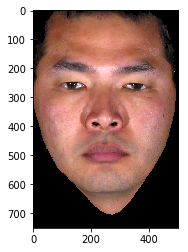

In [107]:
#path = path + 'final/'
# Displaying one image to check
img=mpimg.imread('/content/drive/My Drive/gender-and-age/final/Raw_0016_011_20050913100034_Portrait.png')
imgplot = plt.imshow(img)
plt.show()

In [0]:
test_indices = test_female_data.index.tolist() + test_male_data.index.tolist()

In [109]:
# total test data
test_data = labels.iloc[test_indices,:]
test_data.head()

,Filename,Gender
117,an2.png,1
118,an3.png,1
119,an4.png,1
113,Raw_1074_116_20050912184026_Portrait.png,0
114,Raw_1147_117_20050913192322_Portrait.png,0


In [110]:
# total train data
train_data = pd.concat([labels, test_data, test_data]).drop_duplicates(keep=False)
train_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0


In [0]:
path = path + 'final/'
# train and test with image name along with paths
train_image_name = [path+each for each in train_data['Filename'].values.tolist()]
test_image_name = [path+each for each in test_data['Filename'].values.tolist()]

In [0]:
# preparing data by processing images using opencv
ROWS = 64
COLS = 64
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%5 == 0: print('Processed {} of {}'.format(i, count))
    
    return data


In [113]:
train = prep_data(train_image_name)
test = prep_data(test_image_name)

Processed 0 of 114
Processed 5 of 114
Processed 10 of 114
Processed 15 of 114
Processed 20 of 114
Processed 25 of 114
Processed 30 of 114
Processed 35 of 114
Processed 40 of 114
Processed 45 of 114
Processed 50 of 114
Processed 55 of 114
Processed 60 of 114
Processed 65 of 114
Processed 70 of 114
Processed 75 of 114
Processed 80 of 114
Processed 85 of 114
Processed 90 of 114
Processed 95 of 114
Processed 100 of 114
Processed 105 of 114
Processed 110 of 114
Processed 0 of 6
Processed 5 of 6


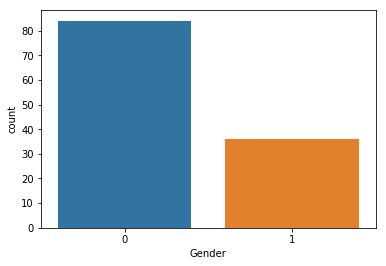

In [114]:
# checking count of male and females
sns.countplot(labels['Gender'])

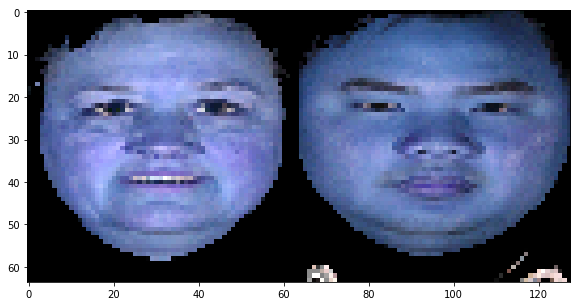

In [115]:
# plotting male and female side by side
def show_male_and_female():
    female = read_image(train_image_name[0])
    male = read_image(train_image_name[2])
    pair = np.concatenate((female, male), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
show_male_and_female()

In [116]:
train_image_name[0]

'/content/drive/My Drive/gender-and-age/final/Raw_0001_001_20050913115022_Portrait.png'

In [0]:
# splitting path of all images into male and female
train_male_image = []
train_female_image = []
for each in train_image_name:
    if each.split('/')[5] in train_male_data['Filename'].values:
        train_male_image.append(each)
    else:
        train_female_image.append(each)

In [0]:
### Creating VGG 16 model for training it on male and female data

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def malefemale():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#   model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))



    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = malefemale()

In [0]:
labs = train_data.iloc[:,1].values.tolist()

nb_epoch = 10
batch_size = 8

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
history = LossHistory()

In [120]:
model.fit(train, labs, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])


Epoch 00008: early stopping


In [0]:
predictions = model.predict(test, verbose=0)

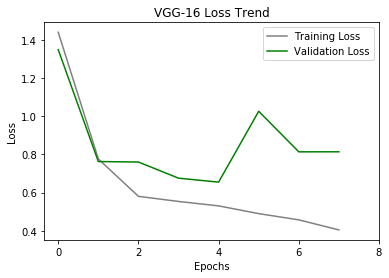

In [128]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'grey', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

 
I am 99.92% sure this is a Male
 


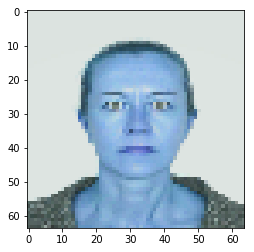

 
I am 99.79% sure this is a Male
 


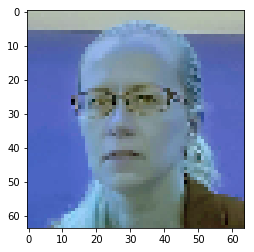

 
I am 99.36% sure this is a Male
 


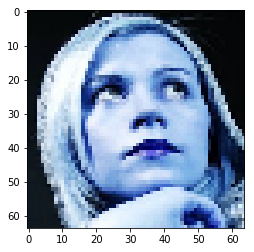

 
I am 89.08% sure this is a Male
 


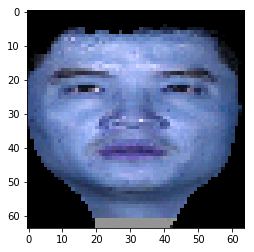

 
I am 81.76% sure this is a Male
 


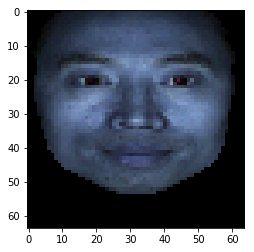

 
I am 98.51% sure this is a Male
 


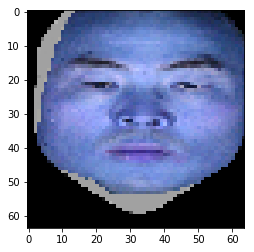

In [131]:
for i in range(0,6):
    print(' ')
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictions[i][0]))
    print(' ') 
    plt.imshow(test[i].T)
    plt.show()

I am 99.36% sure this is a Male


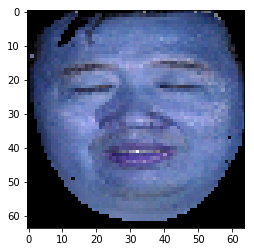

I am 89.08% sure this is a Male


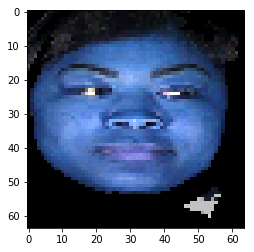

I am 81.76% sure this is a Male


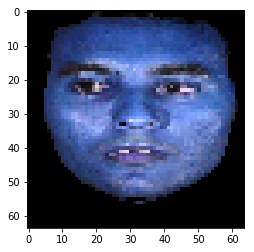

I am 98.51% sure this is a Male


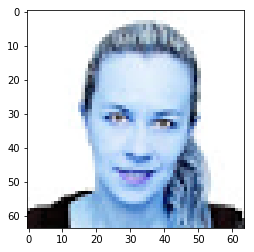

I am 99.92% sure this is a Male


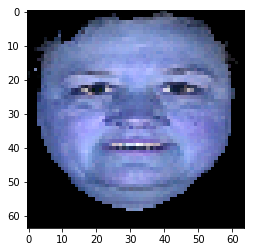

In [124]:
for a in range(-4,1):
    if predictions[a, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictions[a][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictions[a][0]))
        
    plt.imshow(train[a].T)
    plt.show()

I am 99.36% sure this is a Male


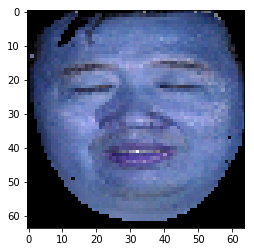

I am 89.08% sure this is a Male


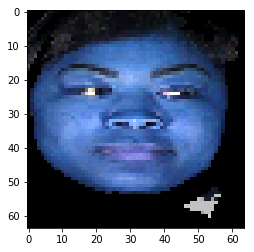

I am 81.76% sure this is a Male


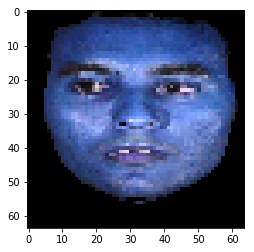

I am 98.51% sure this is a Male


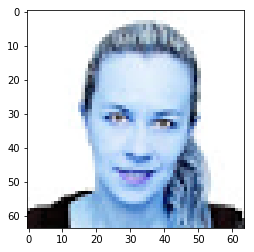

I am 99.92% sure this is a Male


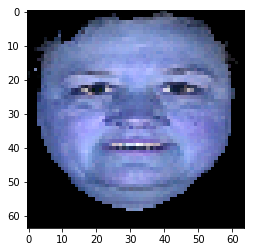

In [125]:
for a in range(-4,1):
    if predictions[a, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictions[a][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictions[a][0]))
        
    plt.imshow(train[a].T)
    plt.show()

I am 98.51% sure this is a Male


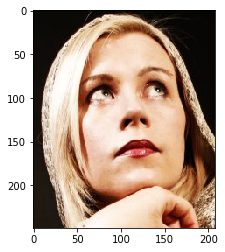

In [126]:
# Displaying one image to check
img=mpimg.imread('/content/drive/My Drive/gender-and-age/final/an4.png')

if predictions[i, 0] >= 0.5: 
     print('I am {:.2%} sure this is a Female'.format(predictions[i][0]))
else: 
     print('I am {:.2%} sure this is a Male'.format(1-predictions[i][0]))
plt.imshow(test[i].T)

imgplot = plt.imshow(img)
plt.show()

I am 98.51% sure this is a Male


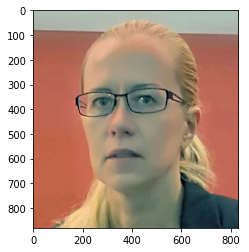

In [127]:
# Displaying one image to check
img=mpimg.imread('/content/drive/My Drive/gender-and-age/final/an3.png')

if predictions[i, 0] >= 0.5: 
     print('I am {:.2%} sure this is a Female'.format(predictions[i][0]))
else: 
     print('I am {:.2%} sure this is a Male'.format(1-predictions[i][0]))
plt.imshow(test[i].T)

imgplot = plt.imshow(img)
plt.show()